# Analyze Queueing and Routing Policies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random
# fix random seed for reproducibility
random.seed(42)
np.random.seed(42)

## 1) Load Dataset

In [3]:
from utils import *
import pandas as pd
from pathlib import Path

results_dir = Path('../results') # Define root results directory

stats_files = sorted(results_dir.glob('**/*stats*.csv')) # Find all files containing "stats" and ending with .csv in all subdirectories
raw_files = sorted(results_dir.glob('**/*raw*.csv')) # Find all files containing "raw" and ending with .csv in all subdirectories
print(f"Found {len(stats_files)} stats CSV files and {len(raw_files)} raw CSV files:")

# Load all stats files into a dictionary of dataframes
stats_dfs = {}
for file_path in stats_files:
    try:
        df = pd.read_csv(file_path)
        # Strip whitespace from column names
        df.columns = df.columns.str.strip()
        # Create key: subfolder_name/filename_stem
        relative_path = file_path.relative_to(results_dir)
        key = str(relative_path.parent / relative_path.stem)
        stats_dfs[key] = df
        print(f"✅ {relative_path} -> shape {df.shape}")
    except Exception as e:
        print(f"❌ Error loading {file_path.name}: {e}")

# Load all raw files into a dictionary of dataframes
raw_dfs = {}
for file_path in raw_files:
    try:
        df = pd.read_csv(file_path)
        # Strip whitespace from column names
        df.columns = df.columns.str.strip()
        # Create key: subfolder_name/filename_stem
        relative_path = file_path.relative_to(results_dir)
        key = str(relative_path.parent / relative_path.stem)
        raw_dfs[key] = df
        print(f"✅ {relative_path} -> shape {df.shape}")
    except Exception as e:
        print(f"❌ Error loading {file_path.name}: {e}")

print(f"\n✅ Loaded {len(stats_dfs)} stats dataframes and {len(raw_dfs)} raw dataframes ✅")

Found 27 stats CSV files and 27 raw CSV files:
✅ cloud/cloud_stats_experiment_anthropic-claude-haiku-4-5_always_cloud_once-per-sec_2025-12-05T10-35-38.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_google-gemini-2-5-flash-always_cloud_once_per_sec_2025-12-05T10-00-00.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_google-gemma-3n-e4b-it_always_cloud_once-per-sec_2025-12-05T08-07-39.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_ibm-granite-granite-4-0-h-micro_always_cloud_once-per-sec_2025-12-05T07-07-33.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_meta-llama-llama-3-2-1b-instruct_always_cloud_once-per-sec_2025-12-04T16-10-54.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_meta-llama-llama-3-2-3b-instruct_always_cloud_once-per-sec_2025-12-05T07-31-00.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_openai-gpt-4o-mini_always_cloud_once-per-sec_2025-12-05T07-18-02.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_qwen-qwen3-8b_always_cloud_once-per-sec_2025-12-05T0

In [4]:
# Check the keys in raw_dfs
print("Available keys in raw_dfs:")
for key in raw_dfs.keys():
    print(key)

Available keys in raw_dfs:
cloud/cloud_raw_experiment_anthropic-claude-haiku-4-5_always_cloud_once-per-sec_2025-12-05T10-35-38
cloud/cloud_raw_experiment_google-gemini-2-5-flash-always_cloud_once_per_sec_2025-12-05T10-00-00
cloud/cloud_raw_experiment_google-gemma-3n-e4b-it_always_cloud_once-per-sec_2025-12-05T08-07-39
cloud/cloud_raw_experiment_ibm-granite-granite-4-0-h-micro_always_cloud_once-per-sec_2025-12-05T07-07-33
cloud/cloud_raw_experiment_meta-llama-llama-3-2-1b-instruct_always_cloud_once-per-sec_2025-12-04T16-10-54
cloud/cloud_raw_experiment_meta-llama-llama-3-2-3b-instruct_always_cloud_once-per-sec_2025-12-05T07-31-00
cloud/cloud_raw_experiment_openai-gpt-4o-mini_always_cloud_once-per-sec_2025-12-05T07-18-02
cloud/cloud_raw_experiment_qwen-qwen3-8b_always_cloud_once-per-sec_2025-12-05T07-52-16
fabian/raw_experiment_Llama-3-2-1B-Instruct-ONNX_always_device_once-per-sec_2025-12-03T20-58-00
fabian/raw_experiment_Qwen3-4B-ONNX_always_device_once-per-sec_2025-12-06T10-14-33
fabia

## Coming up with a routing policy
We want to find out the optimal Threshold T here for our "smart" scheduling policy. On the hardware we tested, mostly the cloud based inference was faster than on-device. We expect that in the future models will get faster and more people will have more access to higher performance hardware in their devices, thats why we lower the inference time for the on-device models by multiplying it with a `on_device_speedup_factor` and performing a linear shift with `on_device_speedup_shift`.

In [36]:
from utils import *

df_cloud_ex = raw_dfs['cloud/cloud_raw_experiment_meta-llama-llama-3-2-1b-instruct_always_cloud_once-per-sec_2025-12-04T16-10-54'].copy()
df_device_ex = raw_dfs['philip/raw_experiment_Llama-3-2-1B-Instruct-ONNX_always_device_once-per-sec_2025-12-04T08-10-53'].copy()

#df_cloud_ex = raw_dfs['cloud/cloud_raw_experiment_ibm-granite-granite-4-0-h-micro_always_cloud_once-per-sec_2025-12-05T07-07-33'].copy()
#df_device_ex = raw_dfs['philip/raw_experiment_granite-4-0-micro-ONNX-web_always_device_once-per-sec_2025-12-04T09-03-29'].copy()

df_cloud_ex = raw_dfs['cloud/cloud_raw_experiment_openai-gpt-4o-mini_always_cloud_once-per-sec_2025-12-05T07-18-02'].copy()
#df_cloud_ex = raw_dfs['cloud/cloud_raw_experiment_anthropic-claude-haiku-4-5_always_cloud_once-per-sec_2025-12-05T10-35-38'].copy()
df_device_ex = raw_dfs['philip/raw_experiment_gemma-3-270m-it-ONNX_always_device_once-per-sec_2025-12-04T08-01-13'].copy()


name_cloud = "openai-gpt-4o-mini"
name_device = "gemma-3-270m-it-ONNX"

on_device_speedup_factor = 1
on_device_speedup_shift = 00 #linear shift factor in ms

cloud_speedup_factor = 1
cloud_speedup_shift = 0

# Apply speedup factor to device inference times
print(f"on-device: Applying speedup factor {on_device_speedup_factor} and shift -{on_device_speedup_shift}ms...")
print(f"cloud: Applying speedup factor {cloud_speedup_factor} and shift -{cloud_speedup_shift}ms...")

# clip(lower=1.0) to prevent negative inference times!
df_device_ex['inference_time_ms'] = (df_device_ex['inference_time_ms'] * on_device_speedup_factor - on_device_speedup_shift).clip(lower=1.0)
df_cloud_ex['inference_time_ms'] = (df_cloud_ex['inference_time_ms'] * cloud_speedup_factor - cloud_speedup_shift).clip(lower=1.0)


on-device: Applying speedup factor 1 and shift -0ms...
cloud: Applying speedup factor 1 and shift -0ms...


We now extract basic per-server metrics from the (manipulated) experiment data.

In [37]:
from utils import *
extract_basic_metrics(df_device_ex, name_device)
extract_basic_metrics(df_cloud_ex, name_cloud)

--- Metrics for gemma-3-270m-it-ONNX ---
  Count:                   500
  Duration:                502.43 s
  Arrival Rate (λ):        0.9952 req/s
  Mean Service Demand (S): 0.3874 s
  Mean Response Time (R):  0.4230 s
  Response Time P95:       0.5964 s
  Utilization (ρ = λ*S):   38.55%
------------------------------
--- Metrics for openai-gpt-4o-mini ---
  Count:                   500
  Duration:                504.36 s
  Arrival Rate (λ):        0.9914 req/s
  Mean Service Demand (S): 0.5506 s
  Mean Response Time (R):  0.6169 s
  Response Time P95:       1.1292 s
  Utilization (ρ = λ*S):   54.59%
------------------------------


{'lambda': 0.9913514499506306,
 'mean_service_time': np.float64(0.5506420000000001),
 'mean_response_time': np.float64(0.616874),
 'p95_response_time': np.float64(1.1292499999999999),
 'utilization': np.float64(0.5458797451037152)}

Using the basic per-server metrics we fit a queueing model per server using the measured service time distribution. To find out what queue model we should use. we need to know the distribution of the interarrival times and the distribution of the service times, therefore we plot them.

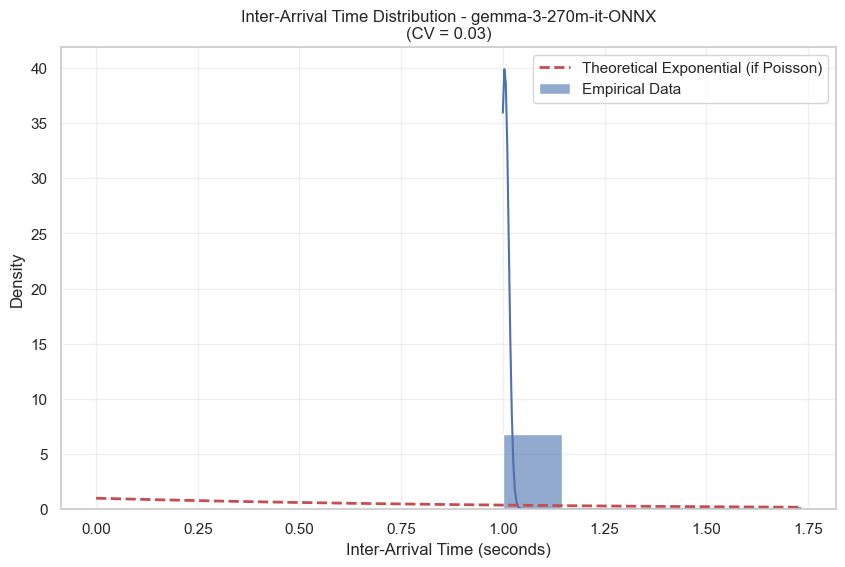

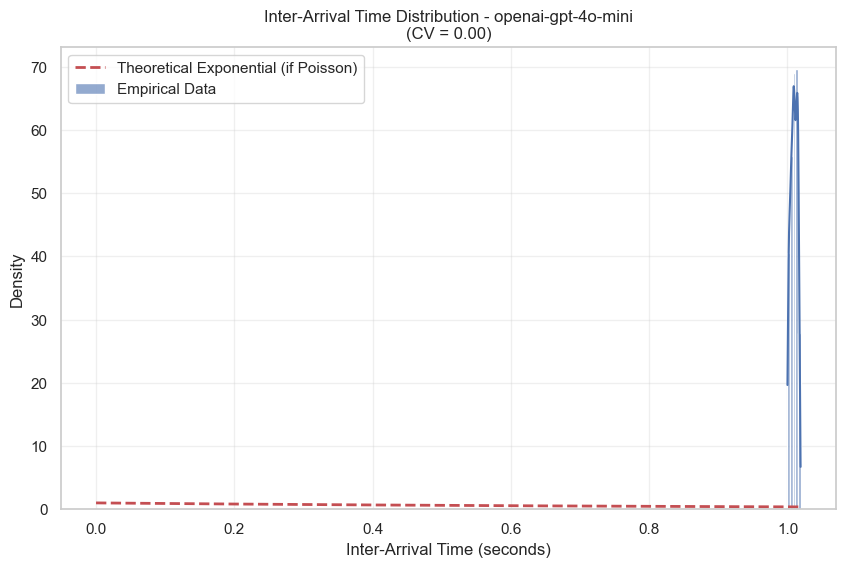

In [38]:
plot_inter_arrival_distribution(df_device_ex, name_device)
plot_inter_arrival_distribution(df_cloud_ex, name_cloud)

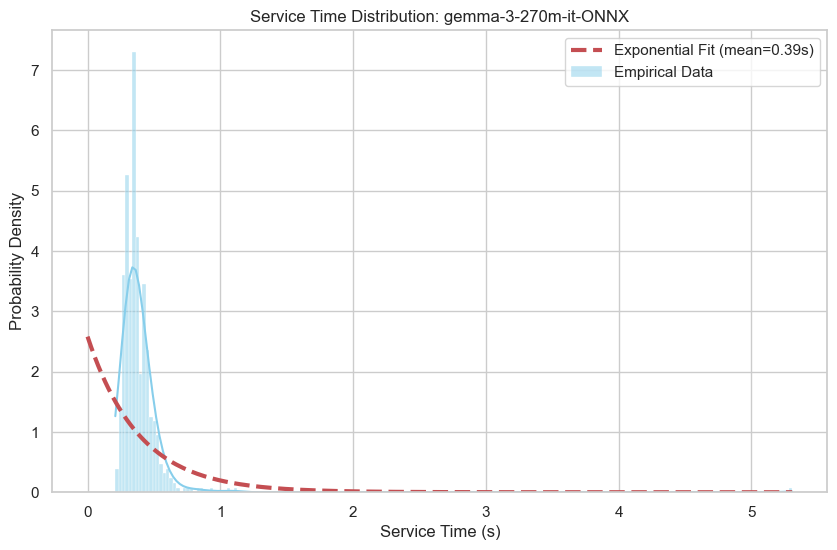

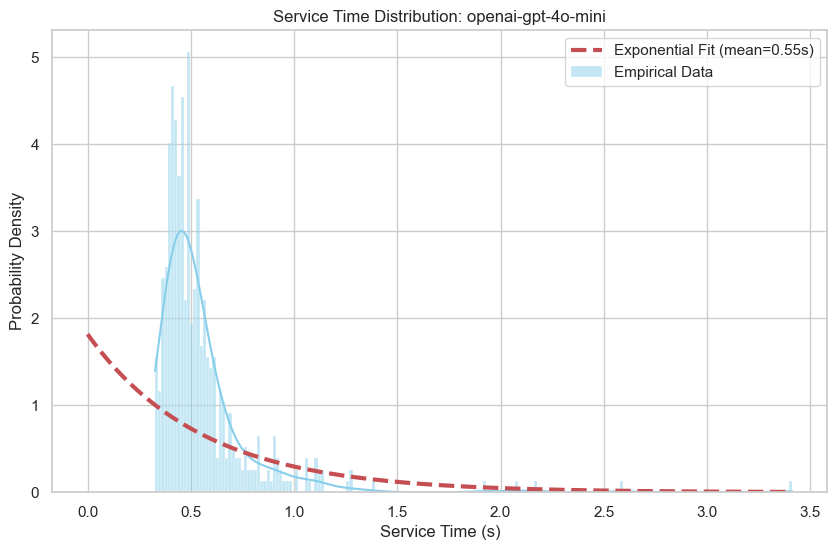

In [39]:
plot_service_time_distribution(df_device_ex, name_device)
plot_service_time_distribution(df_cloud_ex, name_cloud)

We can see that the interarrival times are roughly deterministic. This matches our expectations, as we did the experiments with 1 request per second. The service time distribution plots show that the empirical service times are not clearly exponential, with different shapes and variances for device and cloud. Therefore, for analysis, we model our cloud and on-device systems as **G/G/1** queues (General Arrival, General Service).

Since there is no exact closed-form solution for the mean waiting time in a G/G/1 queue, we use **Kingman's Approximation** (see lecture/literature). The expected waiting time $E[T_Q]$ is approximated as:

$$
E[T_Q] \approx \frac{\rho}{1-\rho} \cdot \frac{c_a^2 + c_s^2}{2} \cdot E[S]
$$

Where:
- $\rho = \lambda E[S]$ is the utilization.
- $E[S]$ is the mean service time.
- $c_a$ is the coefficient of variation of inter-arrival times ($c_a = \sigma_a / \mu_a$).
- $c_s$ is the coefficient of variation of service times ($c_s = \sigma_s / \mu_s$).

This formula generalizes the queueing behavior:
1.  **For our Experiment (G/G/1):** Since arrivals are deterministic, $c_a \approx 0$. The waiting time is driven purely by the service variability ($c_s^2$).
2.  **For M/G/1 (Theoretical):** If we assume random Poisson arrivals, $c_a = 1$. In this case, Kingman's formula simplifies back to the Pollaczek–Khinchine formula.

Using this approximation, we can analytically compute the expected mean response time for both our specific experiment ($c_a=0$) and for a hypothetical real-world scenario with random user arrivals ($c_a=1$).

G/G/1 Analysis | Lambda: 0.9952 | Ca: 0.0 (0=Det, 1=Exp)


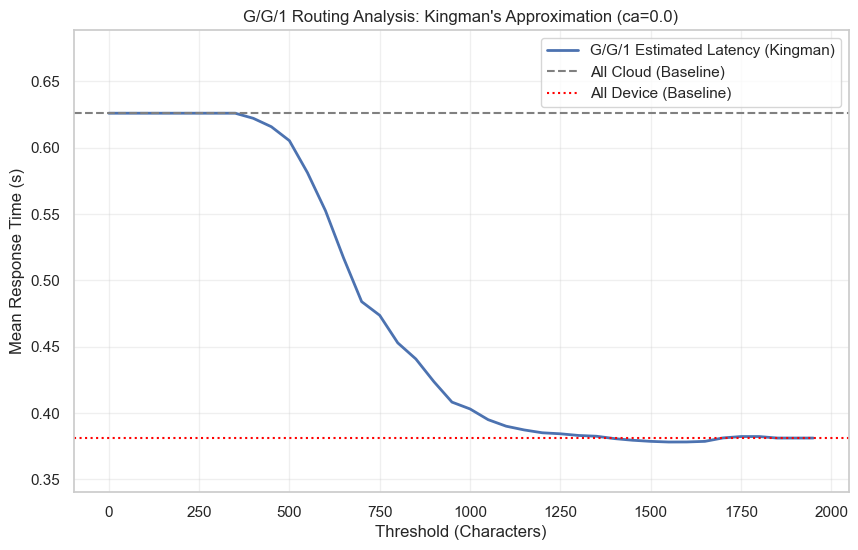

In [40]:
from utils import *

# --- Run Analysis ---
thresholds = range(0, 2000, 50)
# ca=0.0 models your deterministic experiment (D/G/1)
gg1_results = analyze_routing_gg1(df_device_ex, df_cloud_ex, thresholds, ca=0.0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(gg1_results['threshold'], gg1_results['avg_latency'], label='G/G/1 Estimated Latency (Kingman)', linewidth=2)
# Baseline
plt.axhline(y=gg1_results.iloc[0]['avg_latency'], color='gray', linestyle='--', label='All Cloud (Baseline)')
plt.axhline(y=gg1_results.iloc[-1]['avg_latency'], color='red', linestyle=':', label='All Device (Baseline)')

finite_vals = gg1_results[gg1_results['avg_latency'] != float('inf')]['avg_latency']
upper_lim = finite_vals.max() * 1.1 if not pd.isna(finite_vals.max()) else 2.0
lower_lim = max(0, finite_vals.min() * 0.9) if not pd.isna(finite_vals.min()) else 0
plt.ylim(lower_lim, upper_lim)

plt.xlabel('Threshold (Characters)')
plt.ylabel('Mean Response Time (s)')
plt.title('G/G/1 Routing Analysis: Kingman\'s Approximation (ca=0.0)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**how to interpret the analyis plot:**
- X-Axis is the Threshold we set for the routing policy. Any prompt with less characters than T is sent to local device, anything longer goes to the cloud. 
- Y-Axis is the Mean Response Time $E[R]$ for the combined system (device and cloud). It's the weighted weighted average time of requests served by device and cloud.
- The optimal Threshold is the minimum of the curve

**To validate the analytical G/G/1 setup (Kingman's approximation), we build a discrete‑event simulation.** We run two variations: one with **Deterministic arrivals** (matching our experiment, $c_a=0$) and one with **Poisson arrivals** (matching theoretical random traffic, $c_a=1$). For each arrival, we apply the routing rule (if size $\le T$ route to device, otherwise to cloud) and simulate the two FCFS queues using empirically sampled service times. For each threshold $T$, we estimate the average response time over many simulated jobs (`num_jobs`) and compare it to the analytical curves. This verifies that the approximation holds for both our specific experimental conditions and general random workloads.

Simulation Lambda: 0.9952 req/s | Ca: 0.0 | Simulating 20000 jobs...
Simulation Lambda: 0.9952 req/s | Ca: 1.0 | Simulating 20000 jobs...


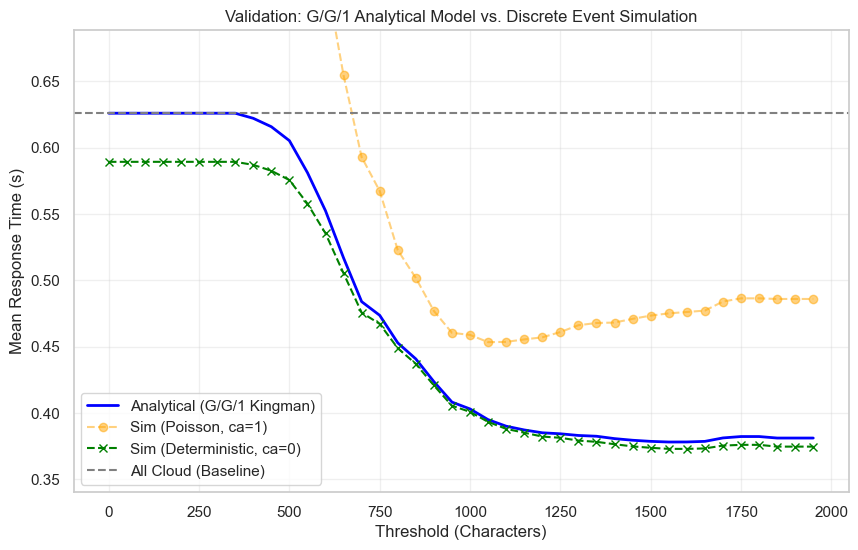

In [41]:
from utils import *

# --- Run Simulation ---
# Use fewer thresholds or jobs if it's too slow
sim_thresholds = range(0, 2000, 50) 

# Calculate Lambda once
lambda_sim = calculate_system_arrival_rate(df_device_ex, df_cloud_ex)

# Run Simulation with Deterministic Arrivals (ca=0.0)
sim_results_det = simulate_routing_validation(df_device_ex, df_cloud_ex, sim_thresholds, lambda_sim, num_jobs=20000, ca=0.0)

# Run Simulation with Poisson Arrivals (ca=1.0)
sim_results_poisson = simulate_routing_validation(df_device_ex, df_cloud_ex, sim_thresholds, lambda_sim, num_jobs=20000, ca=1.0)

# --- Plot Comparison ---
plt.figure(figsize=(10, 6))
# Note: Using gg1_results from the previous cell (Analytical Model)
plt.plot(gg1_results['threshold'], gg1_results['avg_latency'], label='Analytical (G/G/1 Kingman)', linewidth=2, color='blue')
plt.plot(sim_results_poisson['threshold'], sim_results_poisson['sim_latency'], 'o--', label='Sim (Poisson, ca=1)', color='orange', alpha=0.5)
plt.plot(sim_results_det['threshold'], sim_results_det['sim_latency'], 'x--', label='Sim (Deterministic, ca=0)', color='green')

# Baseline
plt.axhline(y=gg1_results.iloc[0]['avg_latency'], color='gray', linestyle='--', label='All Cloud (Baseline)')

# Dynamic Limits
finite_vals = gg1_results[gg1_results['avg_latency'] != float('inf')]['avg_latency']
upper_lim = finite_vals.max() * 1.1 if not pd.isna(finite_vals.max()) else 2.0
lower_lim = max(0, finite_vals.min() * 0.9) if not pd.isna(finite_vals.min()) else 0
plt.ylim(lower_lim, upper_lim)

plt.xlabel('Threshold (Characters)')
plt.ylabel('Mean Response Time (s)')
plt.title('Validation: G/G/1 Analytical Model vs. Discrete Event Simulation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The discrete-event simulation shows slightly lower latency than the Kingman approximation. This is expected, as Kingman's formula is an upper-bound approximation that tends to overestimate waiting times for deterministic arrivals at non-saturated utilization levels.


Now we want to look at a fully simulated version. Here we don't sample arrival- and inference time from our experiments, but we generate them artificially. Earlier we identified a linear relationship between input size and inference time, we will use this to generate accurate distributions to sample pairs of input sizes and inference times.

--- gemma-3-270m-it-ONNX ---
Slope: 0.000508 s/char
Intercept: -0.051748 s
R-squared: 0.4969


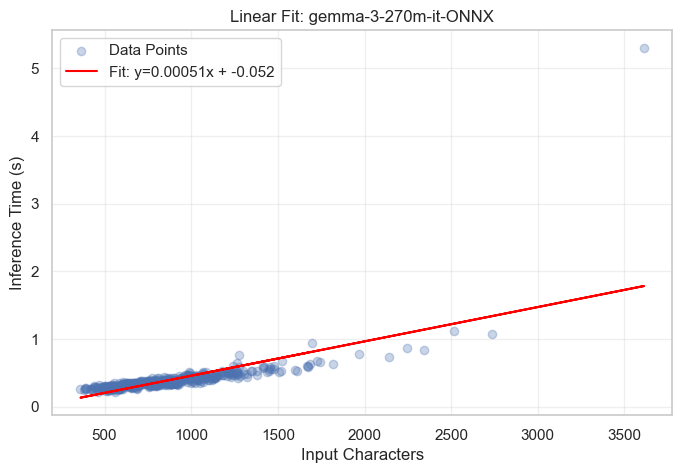

--- openai-gpt-4o-mini ---
Slope: 0.000092 s/char
Intercept: 0.471355 s
R-squared: 0.0141


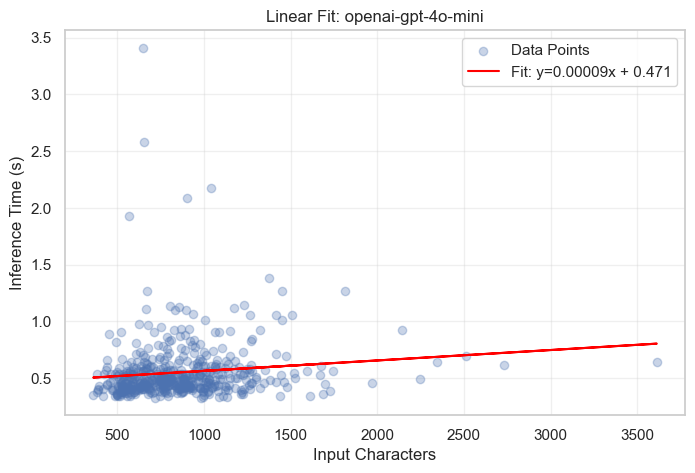


Simulation Params -> Char: (864.7, 340.3)


In [42]:
# Get parameters for Device
slope_dev, int_dev = estimate_linear_relationship(df_device_ex, name_device)

# Get parameters for Cloud
slope_cloud, int_cloud = estimate_linear_relationship(df_cloud_ex, name_cloud)

# Get parameters for Input Character Distribution
char_mean = df_device_ex['number_of_characters'].mean()
char_std = df_device_ex['number_of_characters'].std()

print(f"\nSimulation Params -> Char: ({char_mean:.1f}, {char_std:.1f})")

We can now take the slope and intercept of the cloud and on-device models and use them to generate sample jobs for our simulation. We will generate Gaussian distributed input sizes and calculate the corresponding inference times using the linear models.

0.9951615246670688


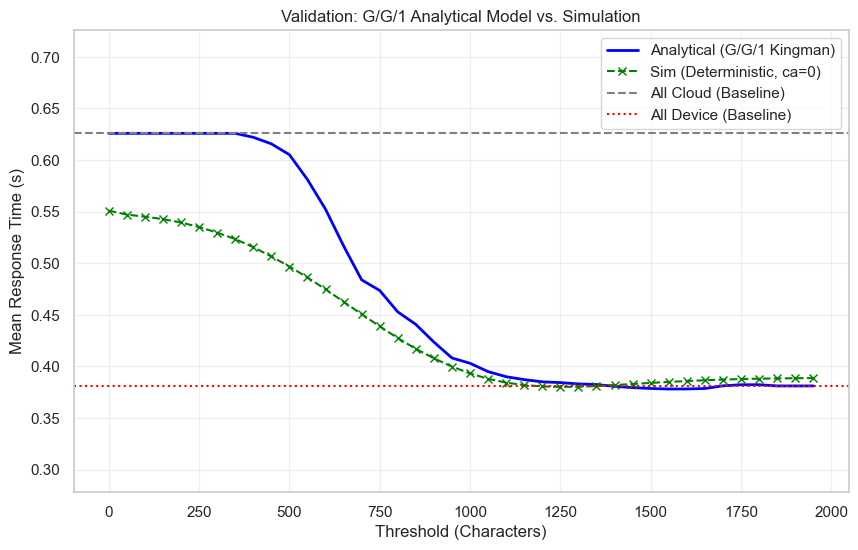

In [43]:
from utils import *

# --- Run Simulation ---
# Use fewer thresholds or jobs if it's too slow
sim_thresholds = range(0, 2000, 50) 

# Calculate Lambda once
lambda_sim = calculate_system_arrival_rate(df_device_ex, df_cloud_ex)
print(lambda_sim)

# Run Simulation with Deterministic Arrivals (ca=0.0)
sim_results_det = simulate_routing_synthetic(sim_thresholds, lambda_sim, num_jobs=100000, ca=0.0, char_params=(char_mean, char_std), dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud))

# Run Simulation with Poisson Arrivals (ca=1.0)
sim_results_poisson = simulate_routing_synthetic(sim_thresholds, lambda_sim, num_jobs=10000, ca=1.0, char_params=(char_mean, char_std), dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud))

# --- Plot Comparison ---
plt.figure(figsize=(10, 6))
# Note: Using gg1_results from the previous cell (Analytical Model)
plt.plot(gg1_results['threshold'], gg1_results['avg_latency'], label='Analytical (G/G/1 Kingman)', linewidth=2, color='blue')
#plt.plot(sim_results_poisson['threshold'], sim_results_poisson['sim_latency'], 'o--', label='Sim (Poisson, ca=1)', color='orange', alpha=0.5)
plt.plot(sim_results_det['threshold'], sim_results_det['sim_latency'], 'x--', label='Sim (Deterministic, ca=0)', color='green')

# Baseline
plt.axhline(y=gg1_results.iloc[0]['avg_latency'], color='gray', linestyle='--', label='All Cloud (Baseline)')
plt.axhline(y=gg1_results.iloc[-1]['avg_latency'], color='red', linestyle=':', label='All Device (Baseline)')

# Dynamic Limits
finite_vals = gg1_results[gg1_results['avg_latency'] != float('inf')]['avg_latency']
upper_lim = finite_vals.max()+0.1 if not pd.isna(finite_vals.max()) else 2.0
lower_lim = max(0, finite_vals.min()-0.1) if not pd.isna(finite_vals.min()) else 0
plt.ylim(lower_lim, upper_lim)

plt.xlabel('Threshold (Characters)')
plt.ylabel('Mean Response Time (s)')
plt.title('Validation: G/G/1 Analytical Model vs. Simulation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

--- Analyzing: On-Device Model (gemma-3-270m-it-ONNX) ---
Mean Service Time (E[S]): 0.3874 s
Service Rate (μ): 2.58 req/s
Service Time CoV (cs): 0.63

--- Analyzing: Cloud Model (openai-gpt-4o-mini) ---
Mean Service Time (E[S]): 0.5506 s
Service Rate (μ): 1.82 req/s
Service Time CoV (cs): 0.48



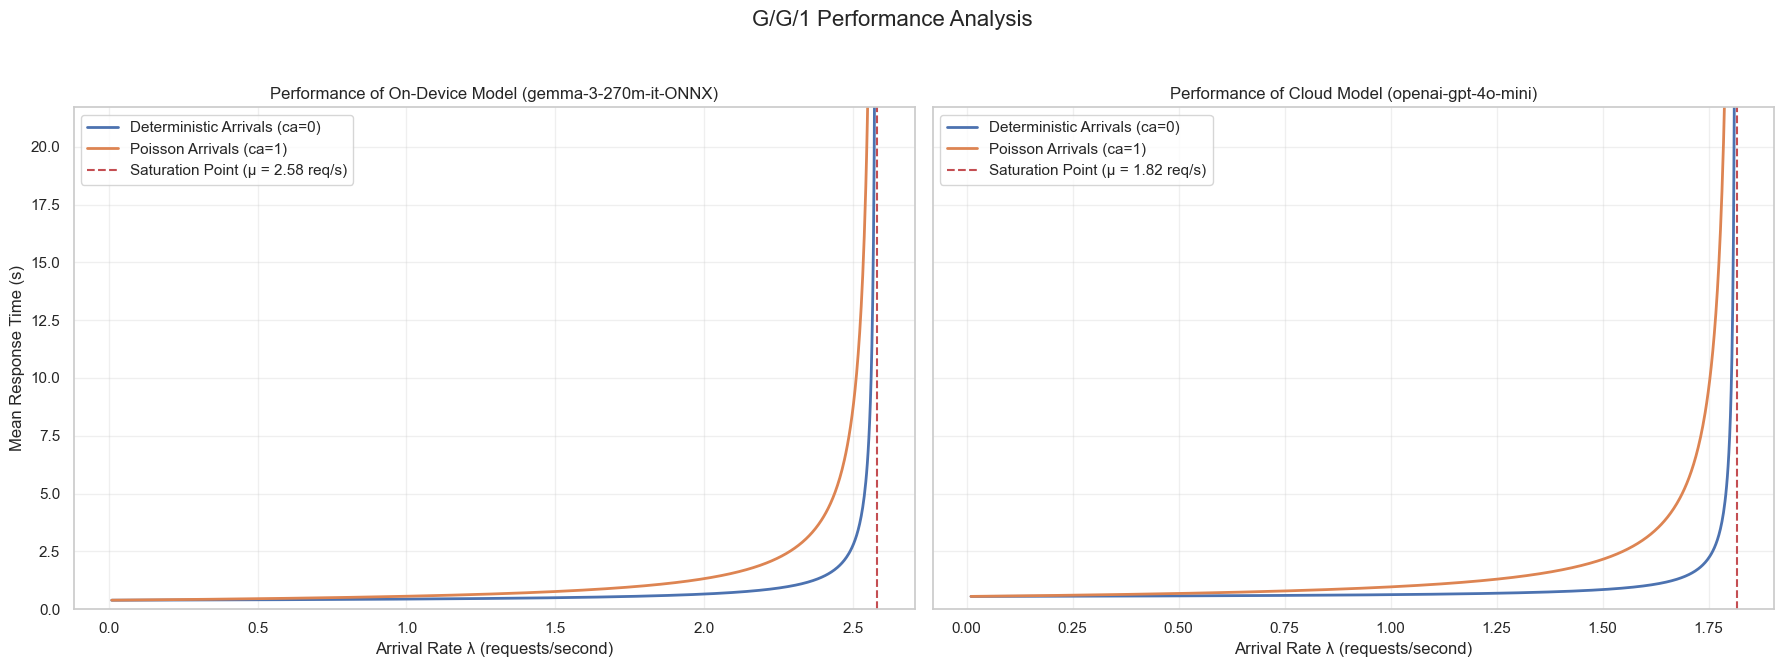

In [44]:
from utils import *
systems_to_analyze = [
    ("On-Device Model (" + name_device + ")", df_device_ex),
    ("Cloud Model (" + name_cloud + ")", df_cloud_ex)
]
mus = plot_system_performance(systems_to_analyze)

We have successfully created a model where we can specify the relationship between input size and inference time for two G/G/1 systems, connected by a threshold-based scheduling policy. This allows us to simulate and optimize the system under various theoretical workloads (deterministic or poisson arrival) and hardware configurations.

## Deriving an input size based policy (Stateless Threshold Policy)
To find the optimal threshold for input size based routing policy, we run simulations for different arrival times lambda and different thresholds and plot the inference time in dependence of the chosen threshold. The optimal threshold is the global minimum of the curve, as this marks the point with the lowest inference time.

**Limitation of Threshold based Policy:** The scheduler decides only based on input size, not based on system state. In case the dataset is not evenly distributed, it can happen that a lot of jobs are sent to the same system even though it's queue is already exploding and the other system is idling.

--- Running simulations for Deterministic Arrivals (ca=0.0) ---
  -> Simulating λ = 0.5 req/s
--- Running simulations for Poisson Arrivals (ca=1.0) ---
  -> Simulating λ = 0.5 req/s


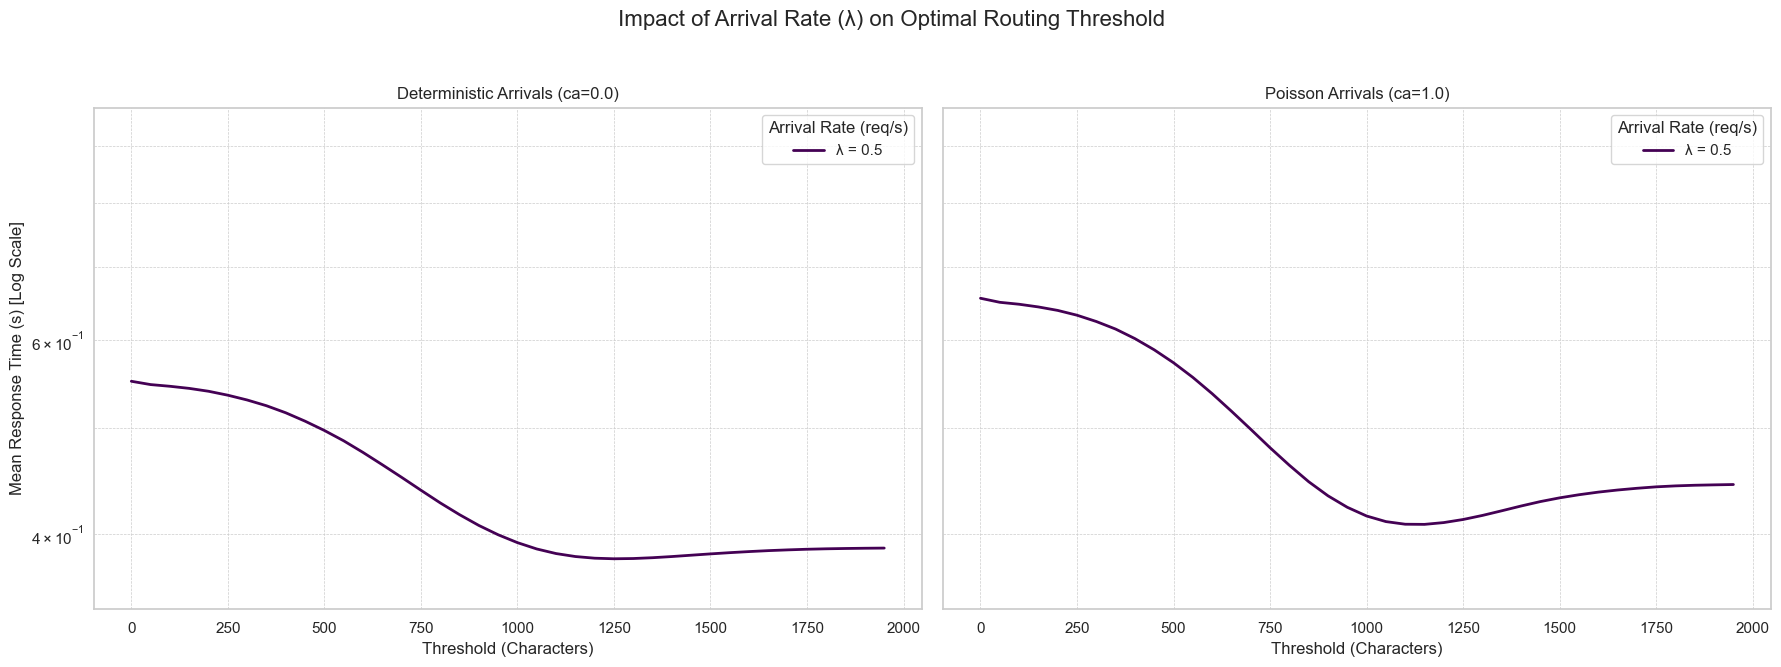

In [45]:
from utils import *

# Define a range of arrival rates to test
#test_lambdas = [0.5, 1.0, 1.5, 2.0, 2.5, 3, 3.5, 4.0, 4.5]
test_lambdas = [0.5]
thresholds= range(0, 2000, 50)

plot_threshold_comparisons(test_lambdas=test_lambdas,
                           thresholds=thresholds,
                           char_params=(char_mean,char_std),
                           dev_model=(slope_dev, int_dev),
                           cloud_model=(slope_cloud, int_cloud))

## Stateful JSEQ Policy to keep track of queues
Here we want to take the state of the systems (queue length of on-device and cloud) into account. The scheduler is effectively asking: "Including the current backlog, which server will finish this specific job faster?" This is the core principle of the "Join the Shortest Expected Queue" (JSEQ) policy.

We then plot the inference time against different lambdas and compare it to the base-models and the threshold method.

--- Running simulations for different arrival rates ---

>>> Simulating for λ = 0.05 req/s...
  Optimal stateless T for λ=0.05 is 1222.0 chars.
  - Always Device (gemma-3-270m-it-ONNX): Done.
  - Always Cloud (openai-gpt-4o-mini): Done.
  - Stateless Threshold : Done.
  - Stateful JSEQ       : Done.

>>> Simulating for λ = 0.10 req/s...
  Optimal stateless T for λ=0.10 is 1222.0 chars.
  - Always Device (gemma-3-270m-it-ONNX): Done.
  - Always Cloud (openai-gpt-4o-mini): Done.
  - Stateless Threshold : Done.
  - Stateful JSEQ       : Done.

>>> Simulating for λ = 0.15 req/s...
  Optimal stateless T for λ=0.15 is 1218.0 chars.
  - Always Device (gemma-3-270m-it-ONNX): Done.
  - Always Cloud (openai-gpt-4o-mini): Done.
  - Stateless Threshold : Done.
  - Stateful JSEQ       : Done.

>>> Simulating for λ = 0.20 req/s...
  Optimal stateless T for λ=0.20 is 1181.0 chars.
  - Always Device (gemma-3-270m-it-ONNX): Done.
  - Always Cloud (openai-gpt-4o-mini): Done.
  - Stateless Threshold : Do

,Total Latency (s),Avg Inference Time (s),Avg Device Queue Length,Avg Cloud Queue Length
Lambda,,,,
0.050000,0.0046,0.3884,0.00,0.00
0.100000,0.0092,0.3877,0.00,0.00
0.150000,0.0142,0.3877,0.00,0.00
0.200000,0.0193,0.3878,0.00,0.00
0.250000,0.0247,0.3882,0.01,0.00
0.300000,0.0304,0.3881,0.01,0.00
0.350000,0.0365,0.3881,0.01,0.00
0.400000,0.0423,0.3880,0.02,0.00
0.450000,0.0487,0.3879,0.02,0.00




--- Results for: Always Cloud (openai-gpt-4o-mini) ---


,Total Latency (s),Avg Inference Time (s),Avg Device Queue Length,Avg Cloud Queue Length
Lambda,,,,
0.050000,0.0078,0.5509,0.00,0.00
0.100000,0.0160,0.5508,0.00,0.00
0.150000,0.0247,0.5508,0.00,0.00
0.200000,0.0341,0.5508,0.00,0.01
0.250000,0.0440,0.5508,0.00,0.01
0.300000,0.0545,0.5508,0.00,0.02
0.350000,0.0658,0.5508,0.00,0.02
0.400000,0.0777,0.5508,0.00,0.03
0.450000,0.0905,0.5508,0.00,0.04




--- Results for: Stateless Threshold ---


,Total Latency (s),Avg Inference Time (s),Avg Device Queue Length,Avg Cloud Queue Length
Lambda,,,,
0.050000,0.0027,0.3798,0.00,0.00
0.100000,0.0054,0.3792,0.00,0.00
0.150000,0.0082,0.3792,0.00,0.00
0.200000,0.0103,0.3799,0.00,0.00
0.250000,0.0130,0.3803,0.00,0.00
0.300000,0.0159,0.3803,0.00,0.00
0.350000,0.0185,0.3806,0.01,0.00
0.400000,0.0204,0.3813,0.01,0.00
0.450000,0.0232,0.3811,0.01,0.00




--- Results for: Stateful JSEQ ---


,Total Latency (s),Avg Inference Time (s),Avg Device Queue Length,Avg Cloud Queue Length
Lambda,,,,
0.050000,0.0008,0.3805,0.00,0.00
0.100000,0.0016,0.3808,0.00,0.00
0.150000,0.0024,0.3817,0.00,0.00
0.200000,0.0033,0.3827,0.00,0.00
0.250000,0.0043,0.3840,0.00,0.00
0.300000,0.0052,0.3847,0.00,0.00
0.350000,0.0061,0.3856,0.00,0.00
0.400000,0.0072,0.3863,0.00,0.00
0.450000,0.0083,0.3869,0.00,0.00


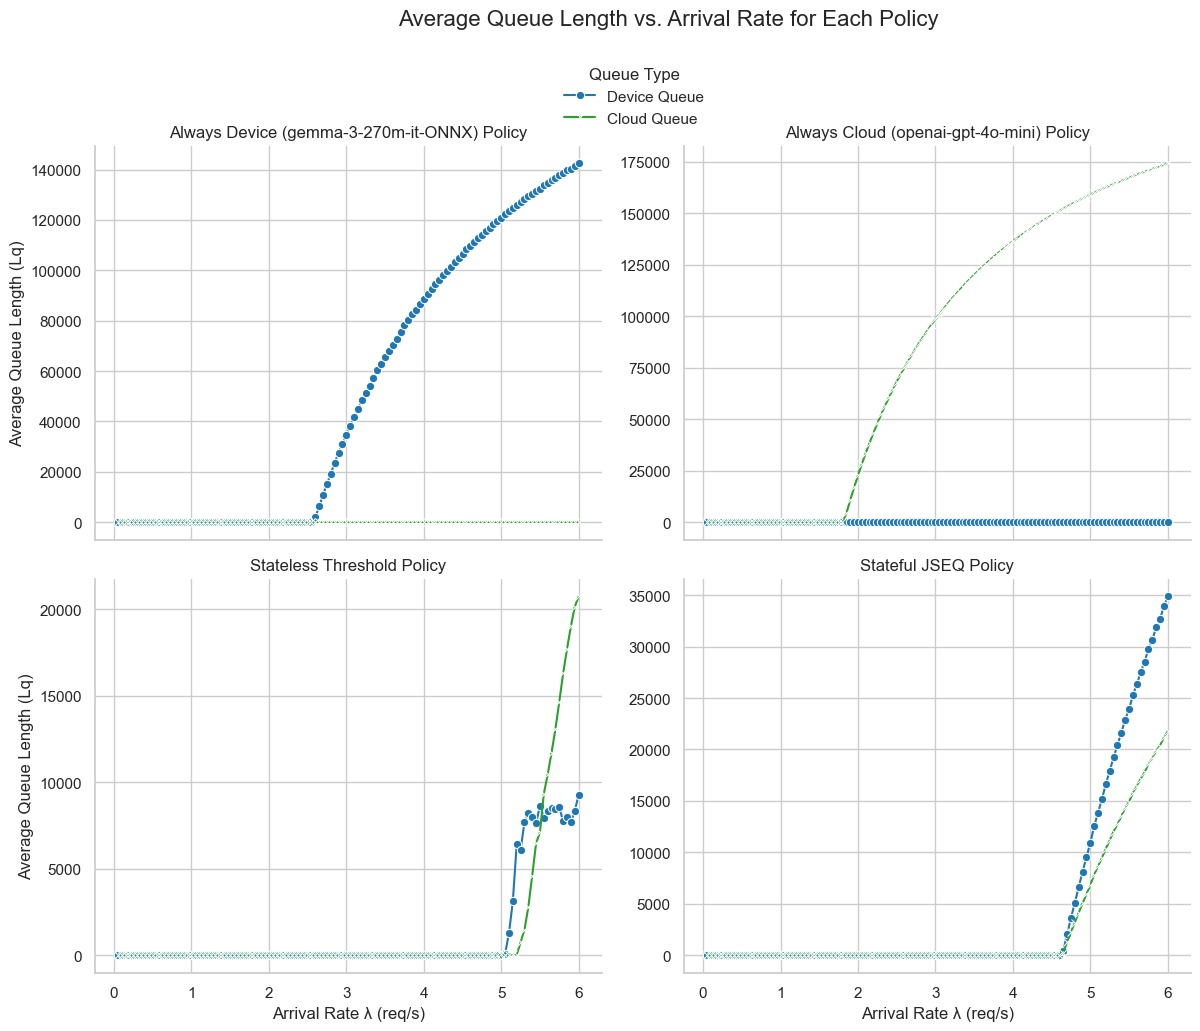

In [62]:
from utils import *

test_lambdas = [0.5, 1.0, 1.5, 2.0, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9] 
test_lambdas = np.linspace(0.05,np.ceil(max(mus)*2),int(np.ceil(max(mus)*2))*20)
#test_lambdas = np.linspace(3, 3.35, 35)

policies_to_test = ['Always Device ('+name_device+')', 'Always Cloud ('+name_cloud+')', 'Stateless Threshold', 'Stateful JSEQ']
    

detailed_results = compare_policy_performance_with_table(test_lambdas=test_lambdas,
                                                         policies_to_test=policies_to_test,
                                                         char_params=(char_mean,char_std),
                                                         dev_model=(slope_dev, int_dev),
                                                         cloud_model=(slope_cloud, int_cloud),
                                                         name_device=name_device,
                                                         name_cloud=name_cloud)

/Users/philipkehl/Library/CloudStorage/OneDrive-UniversitaetBern/Semester 3/Modeling and Scaling of Generative AI Systems/UNIBE_MSGAI_HS25_Project/analyse/utils.py:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  accuracies = []


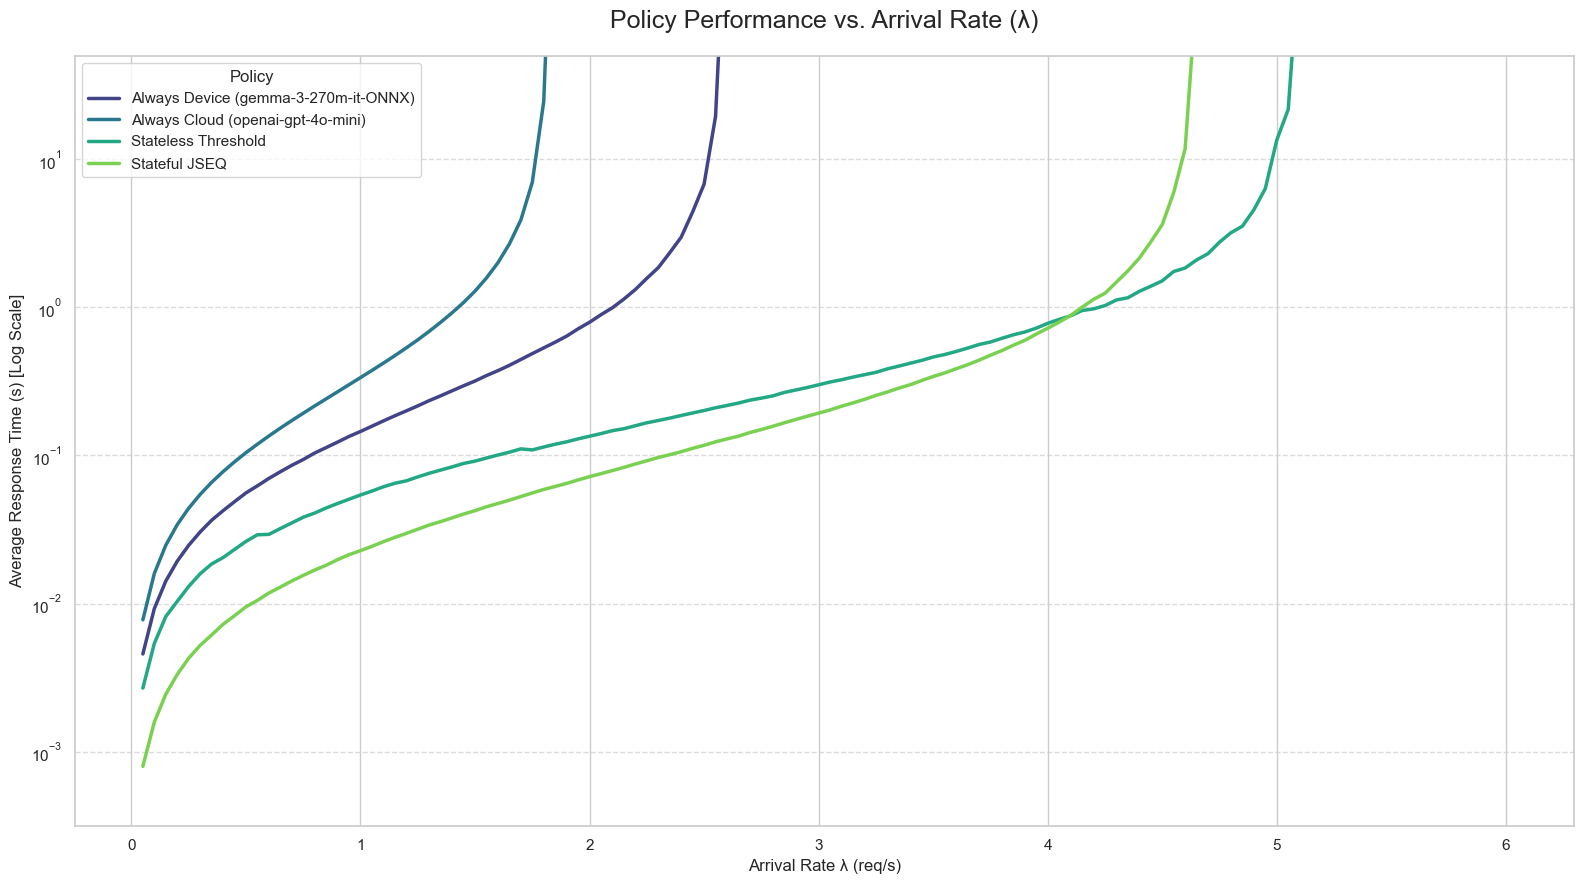

In [63]:
plot_policy_comparison(detailed_results, policies_to_test)

# gemma & haiku

In [5]:
from utils import *

df_cloud_ex = raw_dfs['cloud/cloud_raw_experiment_meta-llama-llama-3-2-1b-instruct_always_cloud_once-per-sec_2025-12-04T16-10-54'].copy()
df_device_ex = raw_dfs['philip/raw_experiment_Llama-3-2-1B-Instruct-ONNX_always_device_once-per-sec_2025-12-04T08-10-53'].copy()

#df_cloud_ex = raw_dfs['cloud/cloud_raw_experiment_ibm-granite-granite-4-0-h-micro_always_cloud_once-per-sec_2025-12-05T07-07-33'].copy()
#df_device_ex = raw_dfs['philip/raw_experiment_granite-4-0-micro-ONNX-web_always_device_once-per-sec_2025-12-04T09-03-29'].copy()

#df_cloud_ex = raw_dfs['cloud/cloud_raw_experiment_openai-gpt-4o-mini_always_cloud_once-per-sec_2025-12-05T07-18-02'].copy()
df_cloud_ex = raw_dfs['cloud/cloud_raw_experiment_anthropic-claude-haiku-4-5_always_cloud_once-per-sec_2025-12-05T10-35-38'].copy()
df_device_ex = raw_dfs['philip/raw_experiment_gemma-3-270m-it-ONNX_always_device_once-per-sec_2025-12-04T08-01-13'].copy()


name_cloud = "anthropic-claude-haiku-4-5"
name_device = "gemma-3-270m-it-ONNX"

on_device_speedup_factor = 1
on_device_speedup_shift = 00 #linear shift factor in ms

cloud_speedup_factor = 1
cloud_speedup_shift = 0

# Apply speedup factor to device inference times
print(f"on-device: Applying speedup factor {on_device_speedup_factor} and shift -{on_device_speedup_shift}ms...")
print(f"cloud: Applying speedup factor {cloud_speedup_factor} and shift -{cloud_speedup_shift}ms...")

# clip(lower=1.0) to prevent negative inference times!
df_device_ex['inference_time_ms'] = (df_device_ex['inference_time_ms'] * on_device_speedup_factor - on_device_speedup_shift).clip(lower=1.0)
df_cloud_ex['inference_time_ms'] = (df_cloud_ex['inference_time_ms'] * cloud_speedup_factor - cloud_speedup_shift).clip(lower=1.0)

on-device: Applying speedup factor 1 and shift -0ms...
cloud: Applying speedup factor 1 and shift -0ms...


--- gemma-3-270m-it-ONNX ---
Slope: 0.000508 s/char
Intercept: -0.051748 s
R-squared: 0.4969


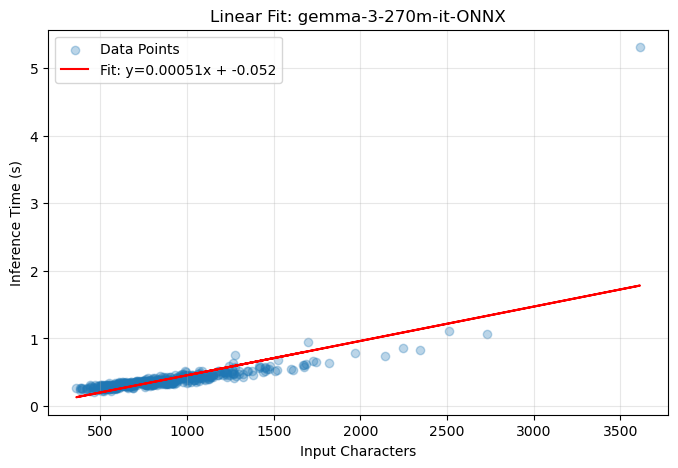

--- anthropic-claude-haiku-4-5 ---
Slope: 0.000092 s/char
Intercept: 1.111050 s
R-squared: 0.0024


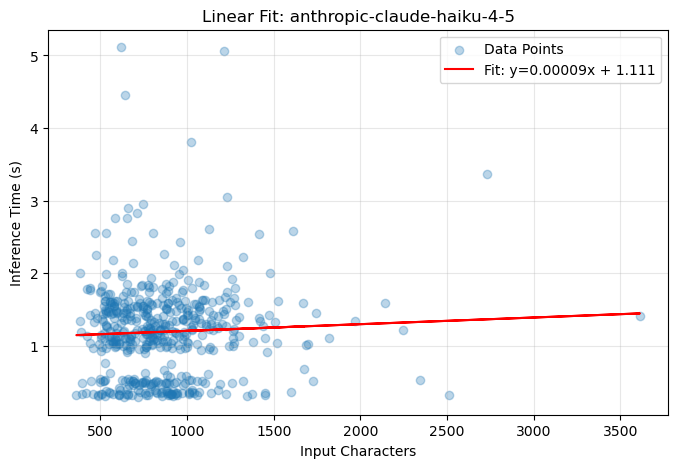


Simulation Params -> Char: (864.7, 340.3)


In [6]:
# Get parameters for Device
slope_dev, int_dev = estimate_linear_relationship(df_device_ex, name_device)

# Get parameters for Cloud
slope_cloud, int_cloud = estimate_linear_relationship(df_cloud_ex, name_cloud)

# Get parameters for Input Character Distribution
char_mean = df_device_ex['number_of_characters'].mean()
char_std = df_device_ex['number_of_characters'].std()

print(f"\nSimulation Params -> Char: ({char_mean:.1f}, {char_std:.1f})")

--- Analyzing: On-Device Model (gemma-3-270m-it-ONNX) ---
Mean Service Time (E[S]): 0.3874 s
Service Rate (μ): 2.58 req/s
Service Time CoV (cs): 0.63

--- Analyzing: Cloud Model (anthropic-claude-haiku-4-5) ---
Mean Service Time (E[S]): 1.1905 s
Service Rate (μ): 0.84 req/s
Service Time CoV (cs): 0.54



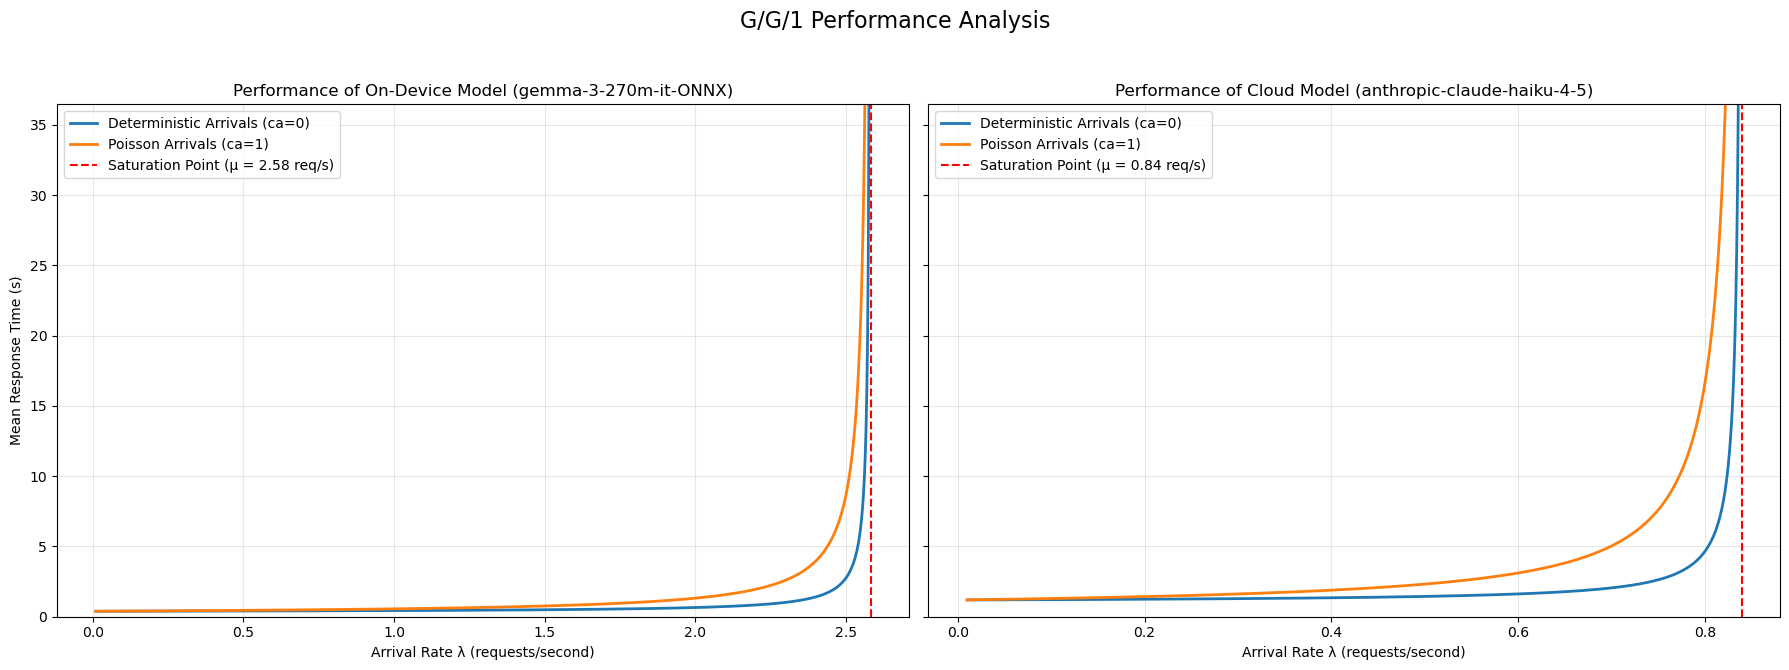

In [7]:
from utils import *
systems_to_analyze = [
    ("On-Device Model (" + name_device + ")", df_device_ex),
    ("Cloud Model (" + name_cloud + ")", df_cloud_ex)
]
mus = plot_system_performance(systems_to_analyze)

--- Running simulations for different arrival rates ---

>>> Simulating for λ = 0.05 req/s...
  Optimal stateless T for λ=0.05 is 1917.0 chars.
  - Always Device (gemma-3-270m-it-ONNX): Done.
  - Always Cloud (anthropic-claude-haiku-4-5): Done.
  - Stateless Threshold : Done.
  - Stateful JSEQ       : Done.

>>> Simulating for λ = 0.10 req/s...
  Optimal stateless T for λ=0.10 is 1917.0 chars.
  - Always Device (gemma-3-270m-it-ONNX): Done.
  - Always Cloud (anthropic-claude-haiku-4-5): Done.
  - Stateless Threshold : Done.
  - Stateful JSEQ       : Done.

>>> Simulating for λ = 0.15 req/s...
  Optimal stateless T for λ=0.15 is 1917.0 chars.
  - Always Device (gemma-3-270m-it-ONNX): Done.
  - Always Cloud (anthropic-claude-haiku-4-5): Done.
  - Stateless Threshold : Done.
  - Stateful JSEQ       : Done.

>>> Simulating for λ = 0.20 req/s...
  Optimal stateless T for λ=0.20 is 1917.0 chars.
  - Always Device (gemma-3-270m-it-ONNX): Done.
  - Always Cloud (anthropic-claude-haiku-4-5): Do

,Total Latency (s),Avg Inference Time (s),Avg Device Queue Length,Avg Cloud Queue Length
Lambda,,,,
0.050000,0.0045,0.3880,0.00,0.00
0.100000,0.0093,0.3880,0.00,0.00
0.150000,0.0142,0.3879,0.00,0.00
0.200000,0.0194,0.3879,0.00,0.00
0.250000,0.0248,0.3875,0.01,0.00
0.300000,0.0305,0.3882,0.01,0.00
0.350000,0.0363,0.3882,0.01,0.00
0.400000,0.0424,0.3878,0.02,0.00
0.450000,0.0487,0.3880,0.02,0.00




--- Results for: Always Cloud (anthropic-claude-haiku-4-5) ---


,Total Latency (s),Avg Inference Time (s),Avg Device Queue Length,Avg Cloud Queue Length
Lambda,,,,
0.050000,0.0374,1.1907,0.00,0.00
0.100000,0.0803,1.1907,0.00,0.01
0.150000,0.1291,1.1906,0.00,0.02
0.200000,0.1853,1.1906,0.00,0.04
0.250000,0.2506,1.1906,0.00,0.06
0.300000,0.3285,1.1907,0.00,0.10
0.350000,0.4224,1.1907,0.00,0.15
0.400000,0.5367,1.1906,0.00,0.21
0.450000,0.6813,1.1907,0.00,0.31




--- Results for: Stateless Threshold ---


,Total Latency (s),Avg Inference Time (s),Avg Device Queue Length,Avg Cloud Queue Length
Lambda,,,,
0.050000,0.0045,0.3883,0.00,0.00
0.100000,0.0093,0.3883,0.00,0.00
0.150000,0.0141,0.3882,0.00,0.00
0.200000,0.0193,0.3883,0.00,0.00
0.250000,0.0246,0.3878,0.01,0.00
0.300000,0.0303,0.3885,0.01,0.00
0.350000,0.0360,0.3885,0.01,0.00
0.400000,0.0421,0.3882,0.02,0.00
0.450000,0.0484,0.3883,0.02,0.00




--- Results for: Stateful JSEQ ---


,Total Latency (s),Avg Inference Time (s),Avg Device Queue Length,Avg Cloud Queue Length
Lambda,,,,
0.050000,0.0044,0.3881,0.00,0.00
0.100000,0.0090,0.3882,0.00,0.00
0.150000,0.0136,0.3883,0.00,0.00
0.200000,0.0184,0.3886,0.00,0.00
0.250000,0.0232,0.3886,0.01,0.00
0.300000,0.0284,0.3896,0.01,0.00
0.350000,0.0333,0.3900,0.01,0.00
0.400000,0.0385,0.3902,0.02,0.00
0.450000,0.0438,0.3909,0.02,0.00


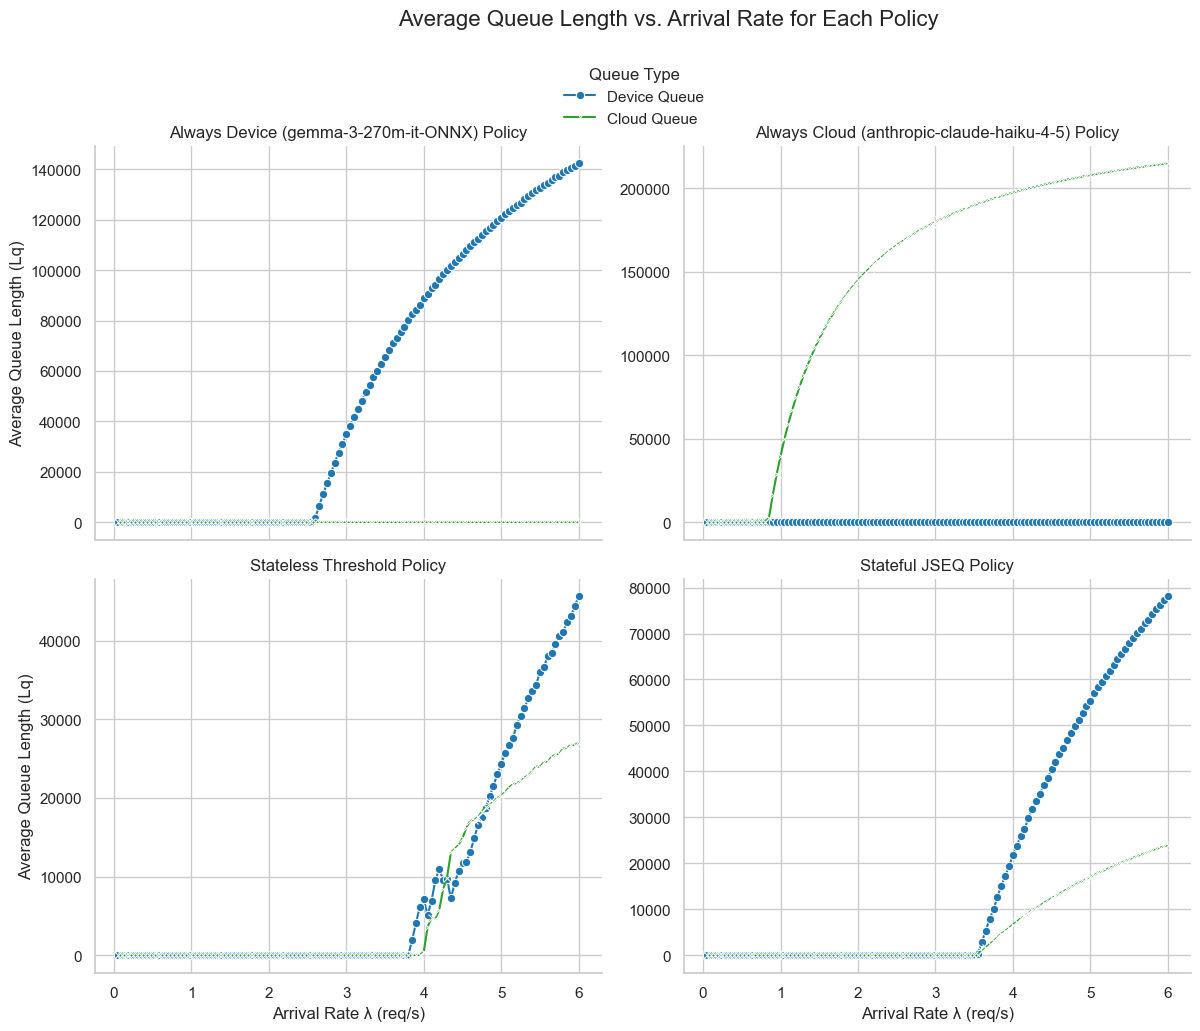

In [9]:
from utils import *

test_lambdas = [0.5, 1.0, 1.5, 2.0, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9] 
test_lambdas = np.linspace(0.05,np.ceil(max(mus)*2),int(np.ceil(max(mus)*2))*20)
#test_lambdas = np.linspace(3, 3.35, 35)

policies_to_test = ['Always Device ('+name_device+')', 'Always Cloud ('+name_cloud+')', 'Stateless Threshold', 'Stateful JSEQ']
    

detailed_results = compare_policy_performance_with_table(test_lambdas=test_lambdas,
                                                         policies_to_test=policies_to_test,
                                                         char_params=(char_mean,char_std),
                                                         dev_model=(slope_dev, int_dev),
                                                         cloud_model=(slope_cloud, int_cloud),
                                                         name_device=name_device,
                                                         name_cloud=name_cloud)

/Users/philipkehl/Library/CloudStorage/OneDrive-UniversitaetBern/Semester 3/Modeling and Scaling of Generative AI Systems/UNIBE_MSGAI_HS25_Project/analyse/utils.py:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  accuracies = []


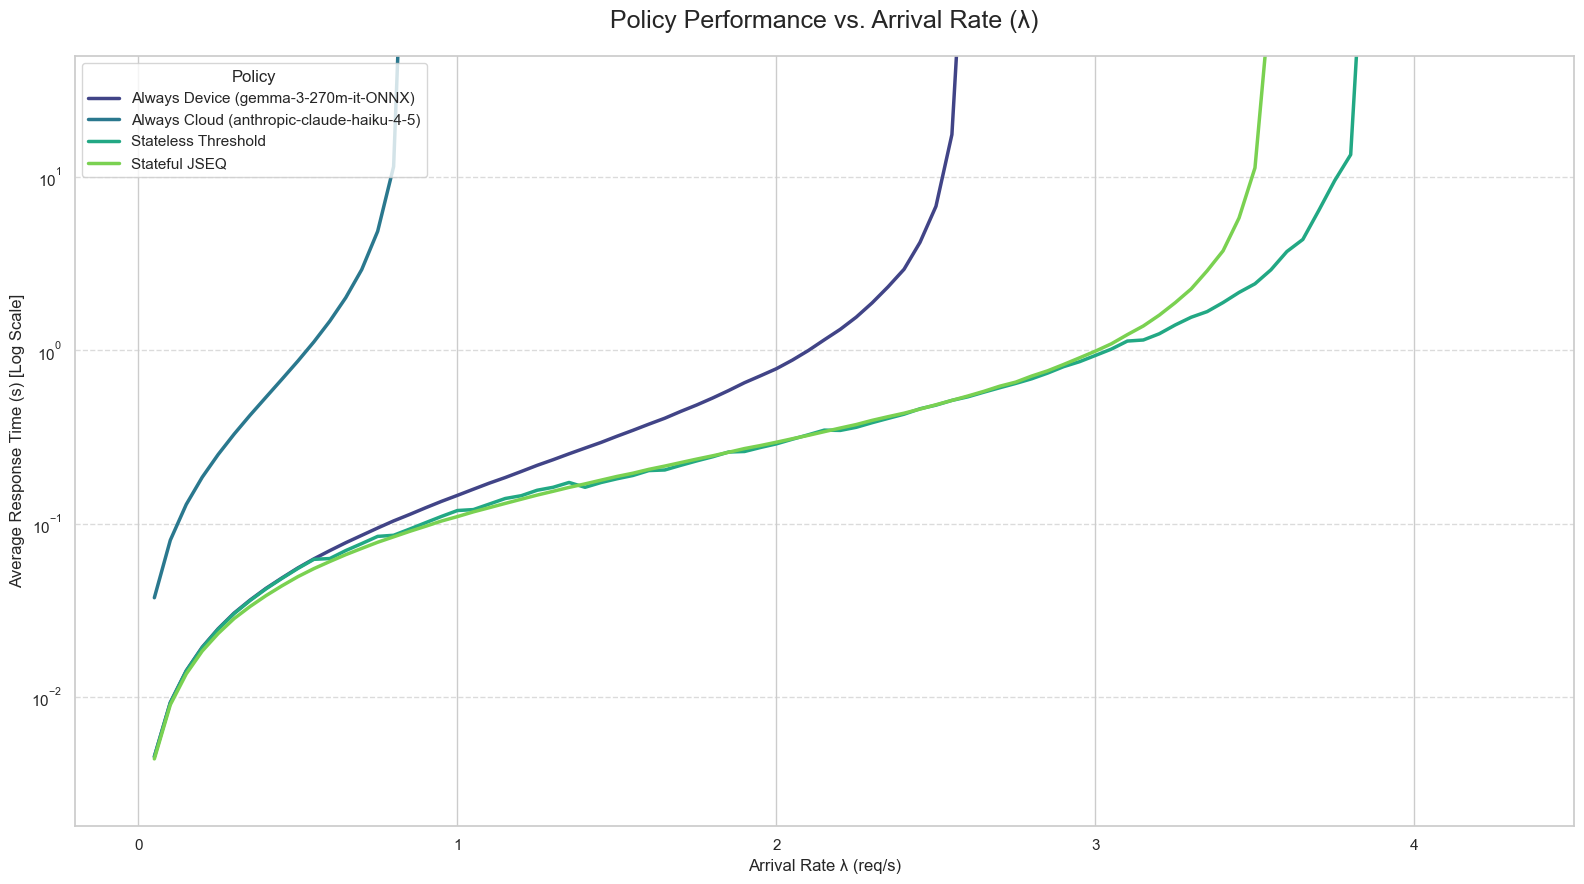

In [12]:
plot_policy_comparison(detailed_results, policies_to_test)

# llama und llama mit speedup 0.5

In [ ]:
from utils import *

df_cloud_ex = raw_dfs['cloud/cloud_raw_experiment_meta-llama-llama-3-2-1b-instruct_always_cloud_once-per-sec_2025-12-04T16-10-54'].copy()
df_device_ex = raw_dfs['philip/raw_experiment_Llama-3-2-1B-Instruct-ONNX_always_device_once-per-sec_2025-12-04T08-10-53'].copy()

name_cloud = "llama-llama-3-2-1b-instruct"
name_device = "Llama-3-2-1B-Instruct-ONNX"

on_device_speedup_factor = 0.5
on_device_speedup_shift = 00 #linear shift factor in ms

cloud_speedup_factor = 1
cloud_speedup_shift = 0

# Apply speedup factor to device inference times
print(f"on-device: Applying speedup factor {on_device_speedup_factor} and shift -{on_device_speedup_shift}ms...")
print(f"cloud: Applying speedup factor {cloud_speedup_factor} and shift -{cloud_speedup_shift}ms...")

# clip(lower=1.0) to prevent negative inference times!
df_device_ex['inference_time_ms'] = (df_device_ex['inference_time_ms'] * on_device_speedup_factor - on_device_speedup_shift).clip(lower=1.0)
df_cloud_ex['inference_time_ms'] = (df_cloud_ex['inference_time_ms'] * cloud_speedup_factor - cloud_speedup_shift).clip(lower=1.0)

In [ ]:
# Get parameters for Device
slope_dev, int_dev = estimate_linear_relationship(df_device_ex, name_device)

# Get parameters for Cloud
slope_cloud, int_cloud = estimate_linear_relationship(df_cloud_ex, name_cloud)

# Get parameters for Input Character Distribution
char_mean = df_device_ex['number_of_characters'].mean()
char_std = df_device_ex['number_of_characters'].std()

print(f"\nSimulation Params -> Char: ({char_mean:.1f}, {char_std:.1f})")

In [ ]:
from utils import *
systems_to_analyze = [
    ("On-Device Model (" + name_device + ")", df_device_ex),
    ("Cloud Model (" + name_cloud + ")", df_cloud_ex)
]
mus = plot_system_performance(systems_to_analyze)

In [ ]:
from utils import *

test_lambdas = [0.5, 1.0, 1.5, 2.0, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9] 
test_lambdas = np.linspace(0.05,np.ceil(max(mus)*2),int(np.ceil(max(mus)*2))*20)
#test_lambdas = np.linspace(3, 3.35, 35)

policies_to_test = ['Always Device ('+name_device+')', 'Always Cloud ('+name_cloud+')', 'Stateless Threshold', 'Stateful JSEQ']
    

detailed_results = compare_policy_performance_with_table(test_lambdas=test_lambdas,
                                                         policies_to_test=policies_to_test,
                                                         char_params=(char_mean,char_std),
                                                         dev_model=(slope_dev, int_dev),
                                                         cloud_model=(slope_cloud, int_cloud),
                                                         name_device=name_device,
                                                         name_cloud=name_cloud)

In [ ]:
plot_policy_comparison(detailed_results, policies_to_test)